# Customer Segmentation & Campaign Response Analysis

In this notebook, we will:
- Preprocess and explore customer data.
- Perform clustering using several methods (K-Means, Agglomerative, DBSCAN, GMM) with detailed visualizations.
- Evaluate and choose the best number of clusters via silhouette scores.
- Build a Random Forest model to predict campaign response.
  
Let's get started!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Clustering & dimensionality reduction libraries
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Supervised learning libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# For dendrogram visualization in Agglomerative Clustering
import scipy.cluster.hierarchy as sch

# Set seaborn style for better aesthetics
sns.set(style="whitegrid")


## Data Loading & Basic Inspection

We'll load the dataset and perform some initial inspections (head, info, description, and missing values).


In [5]:
# Load the dataset from an Excel file
data = pd.read_excel("marketing_campaign1.xlsx")

# Basic inspection
print("Dataset Head:")
print(data.head())
print("\nDataset Info:")
print(data.info())
print("\nDataset Description:")
print(data.describe())
print("\nMissing Values per Column:")
print(data.isnull().sum())


Dataset Head:
     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  2012-09-04       58       635  ...                  7             0   
1  2014-03-08       38        11  ...                  5             0   
2  2013-08-21       26       426  ...                  4             0   
3  2014-02-10       26        11  ...                  6             0   
4  2014-01-19       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0

## Data Preprocessing & Feature Engineering

In this section, we:
- Convert date columns.
- Impute missing values and handle outliers.
- Create new features such as `Age`, `Total_Spending`, and combine children information.
- Group categorical variables (Marital Status, Education) and drop redundant columns.


In [8]:
# Convert date column to datetime format
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], format='%d-%m-%Y')
print("\nThe newest customer's enrolment date:", data['Dt_Customer'].max())
print("The oldest customer's enrolment date:", data['Dt_Customer'].min())

# Impute missing Income values with median
median_income = data['Income'].median()
data['Income'] = data['Income'].fillna(median_income)
print(f"\nFilled missing Income values with median: {median_income}")

# Handle outliers in Income using the IQR method
Q1 = data['Income'].quantile(0.25)
Q3 = data['Income'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"\nIncome lower bound: {lower_bound:.2f}, upper bound: {upper_bound:.2f}")
data['Income'] = np.clip(data['Income'], lower_bound, upper_bound)

# Feature Engineering
data['Age'] = 2025 - data['Year_Birth']

spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 
                 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
data['Total_Spending'] = data[spending_cols].sum(axis=1)
spending_cap = data['Total_Spending'].quantile(0.99)
data['Total_Spending'] = np.where(data['Total_Spending'] > spending_cap, spending_cap, data['Total_Spending'])

# Combine Kidhome and Teenhome into a single 'Children' feature
data['Children'] = data['Kidhome'] + data['Teenhome']
data.drop(['Kidhome', 'Teenhome'], axis=1, inplace=True)

# Group Marital Status into 'Single' and 'Family'
single_statuses = ['Single', 'Divorced', 'Widow', 'Alone', 'YOLO', 'Absurd']
family_statuses = ['Married', 'Together']
data['Marital_Group'] = data['Marital_Status'].apply(lambda x: 'Single' if x in single_statuses 
                                                      else ('Family' if x in family_statuses else x))

# Education segmentation
data['Education'] = data['Education'].replace({
    'Basic': 'Undergraduate', 
    '2n Cycle': 'Undergraduate', 
    'Graduation': 'Graduate', 
    'Master': 'Postgraduate', 
    'PhD': 'Postgraduate'
})

# Drop redundant columns
data.drop(['ID', 'Year_Birth', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)



The newest customer's enrolment date: 2014-06-29 00:00:00
The oldest customer's enrolment date: 2012-07-30 00:00:00

Filled missing Income values with median: 51381.5

Income lower bound: -13587.75, upper bound: 117416.25


## Exploratory Data Analysis (EDA) & Visualizations

We will visualize key aspects of our data with:
- Pair plots
- Bar charts for average spending by marital group
- Histograms for distributions
- A correlation heatmap


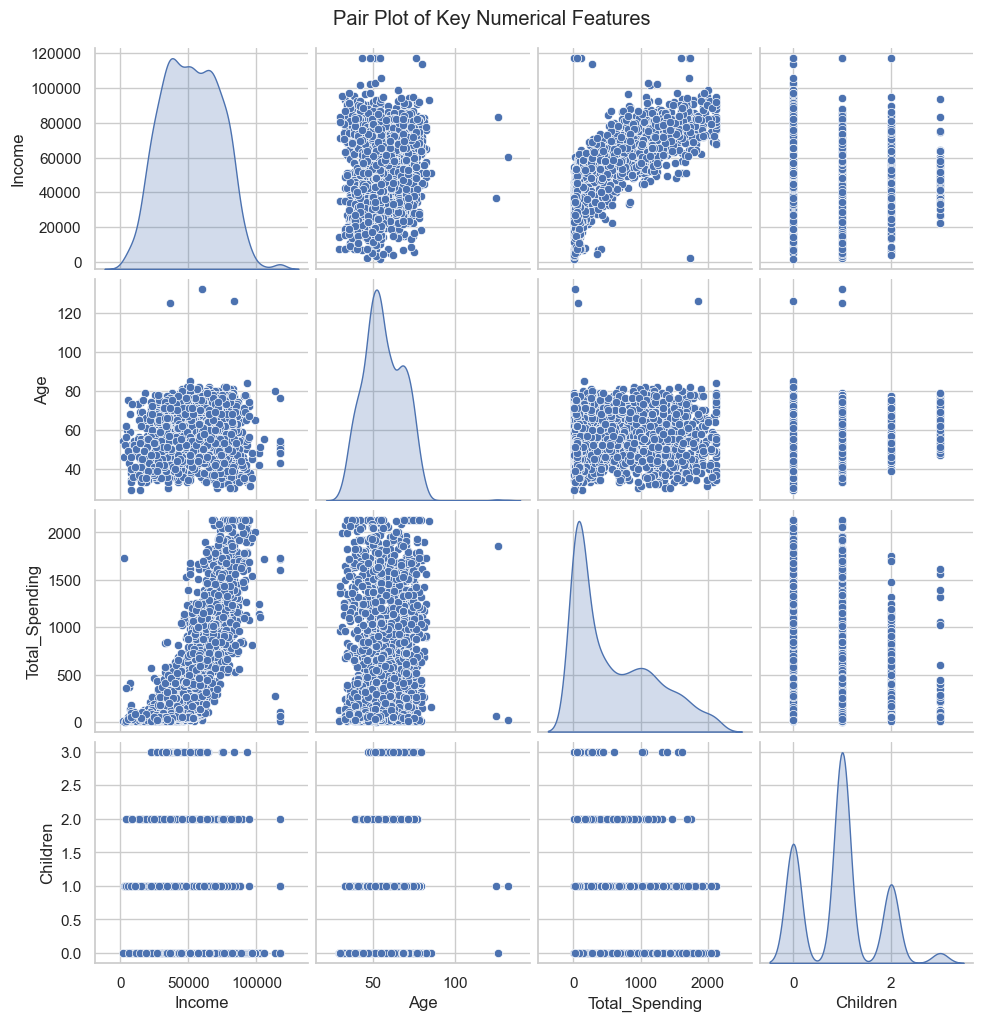

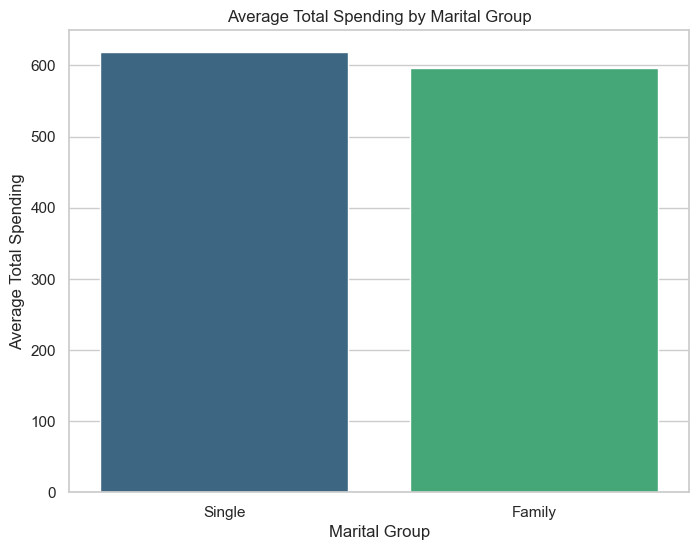

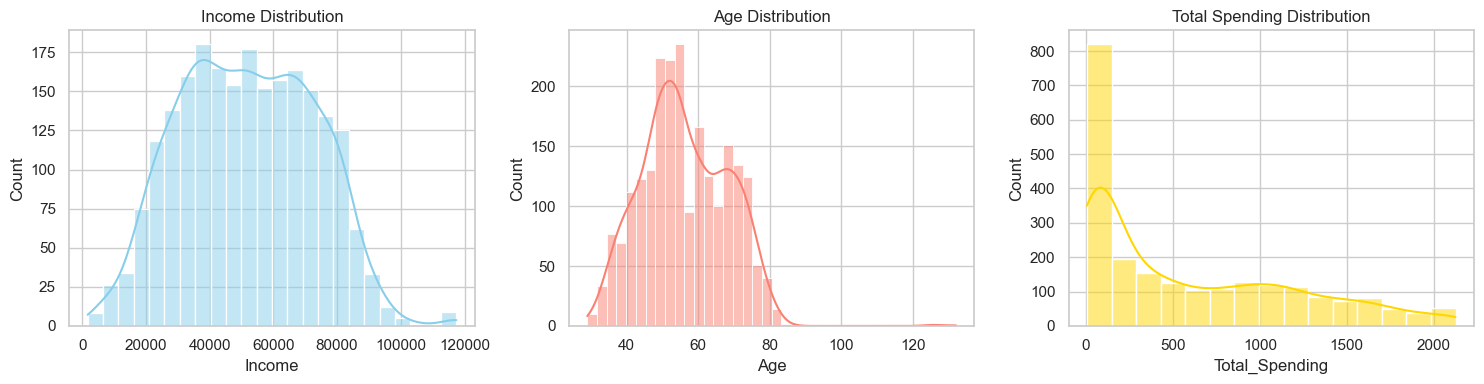

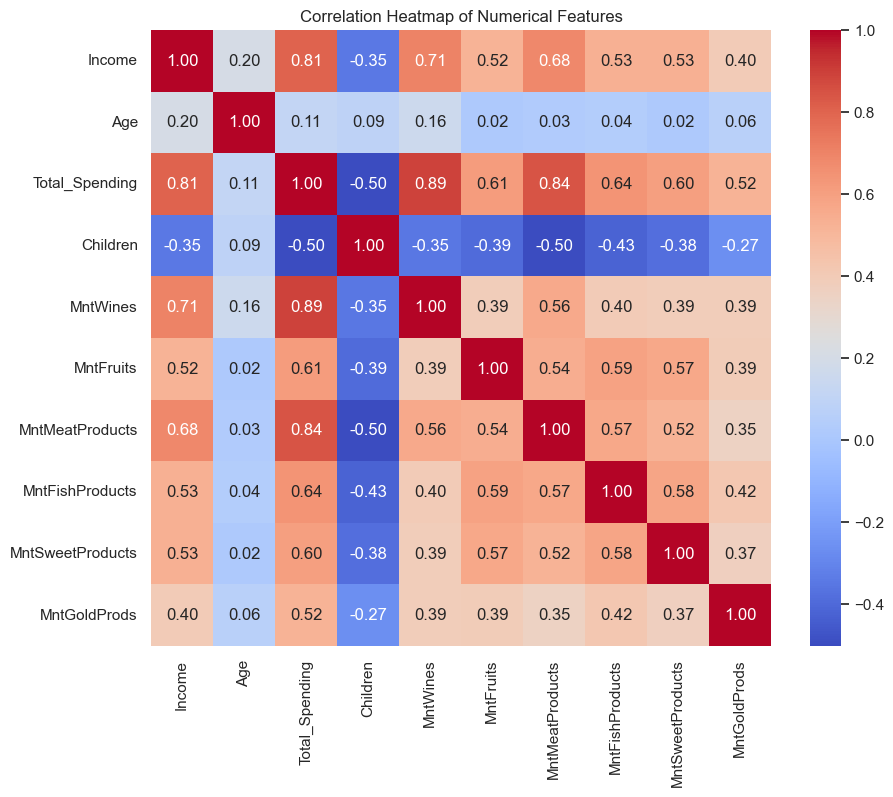

In [32]:
# Pair Plot for key numerical features
sns.pairplot(data[['Income', 'Age', 'Total_Spending', 'Children']], diag_kind='kde', palette='coolwarm')
plt.suptitle("Pair Plot of Key Numerical Features", y=1.02)
plt.show()

# Bar Chart: Average Total Spending by Marital Group
plt.figure(figsize=(8,6))
avg_spending_by_group = data.groupby('Marital_Group')['Total_Spending'].mean().sort_values(ascending=False)
sns.barplot(x=avg_spending_by_group.index, y=avg_spending_by_group.values, palette='viridis')
plt.title("Average Total Spending by Marital Group")
plt.xlabel("Marital Group")
plt.ylabel("Average Total Spending")
plt.show()

# Histograms for Income, Age, and Total Spending
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
sns.histplot(data['Income'], kde=True, color='skyblue')
plt.title("Income Distribution")
plt.subplot(1,3,2)
sns.histplot(data['Age'], kde=True, color='salmon')
plt.title("Age Distribution")
plt.subplot(1,3,3)
sns.histplot(data['Total_Spending'], kde=True, color='gold')
plt.title("Total Spending Distribution")
plt.tight_layout()
plt.show()

# Correlation Heatmap of Numerical Features
plt.figure(figsize=(10,8))
num_features = ['Income', 'Age', 'Total_Spending', 'Children'] + spending_cols
sns.heatmap(data[num_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


## Model Building: Clustering & Visualization

First, we set up the features for clustering and standardize them. We then project the standardized data to 2D using PCA for visualization purposes.


In [14]:
# Define features for clustering and standardize them
clustering_features = ['Income', 'Age', 'Total_Spending']
X_orig = data[clustering_features]
scaler = StandardScaler()
X = scaler.fit_transform(X_orig)

# PCA for visualizations across clustering models
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
data['PCA1'] = X_pca[:, 0]
data['PCA2'] = X_pca[:, 1]


## K-Means Clustering

We'll evaluate K-Means clustering by looping through a range of k values. We use the elbow method and silhouette scores to determine the best k.



----- K-Means Clustering -----


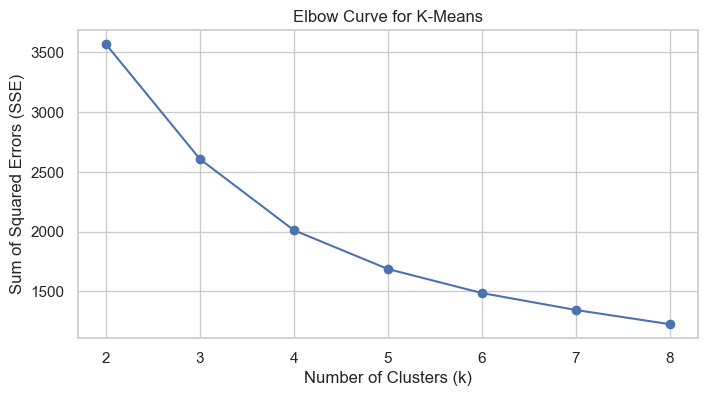

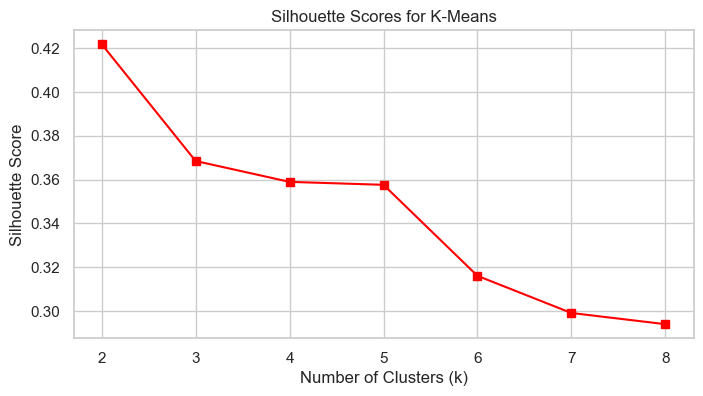


----- Additional K-Means Cluster Visualizations for each k -----


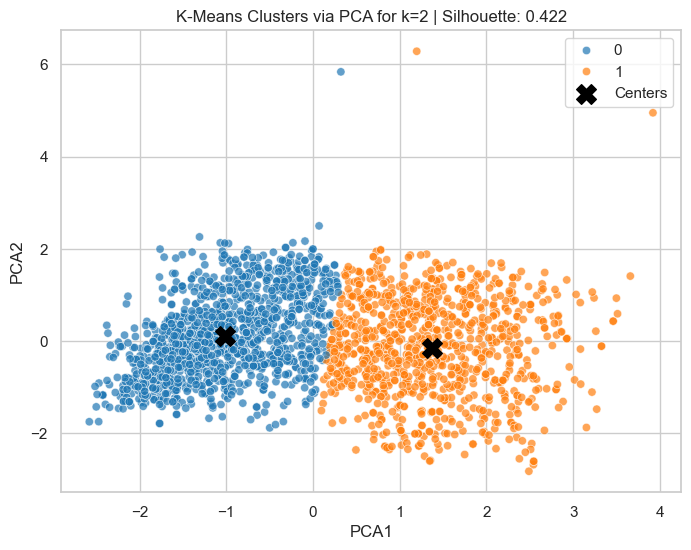

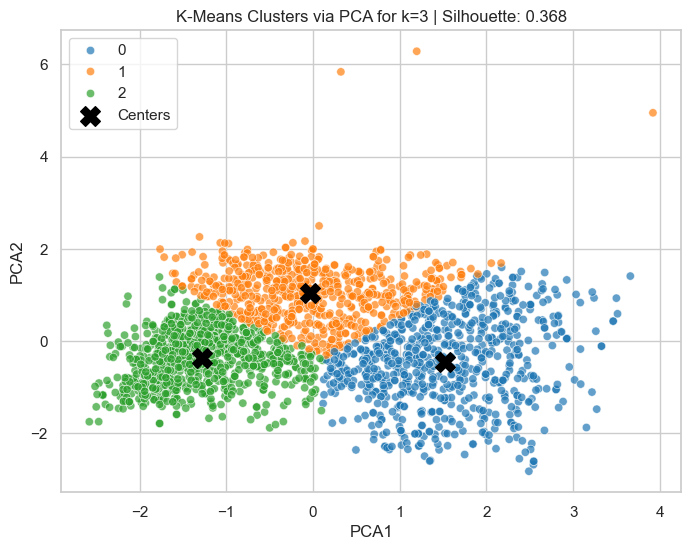

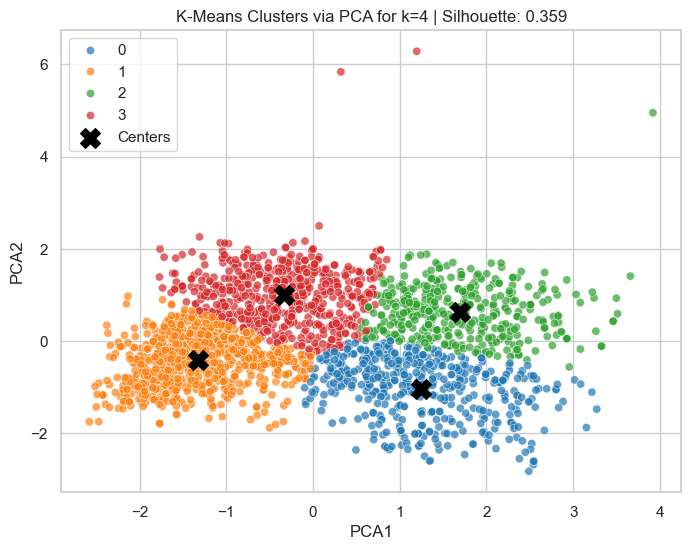

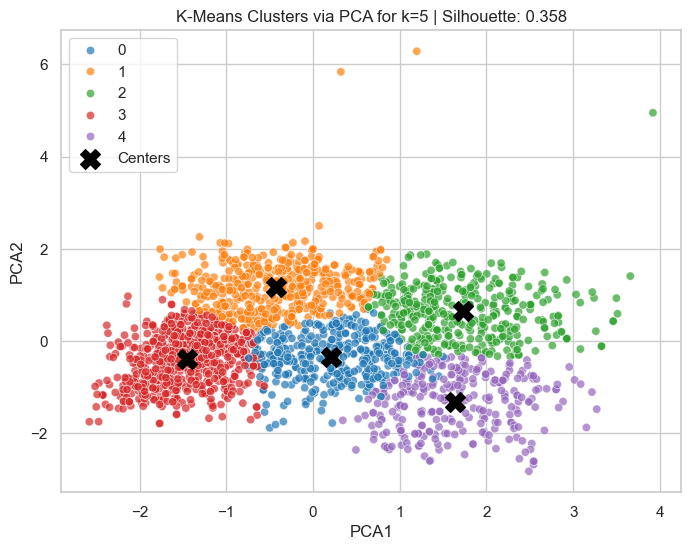

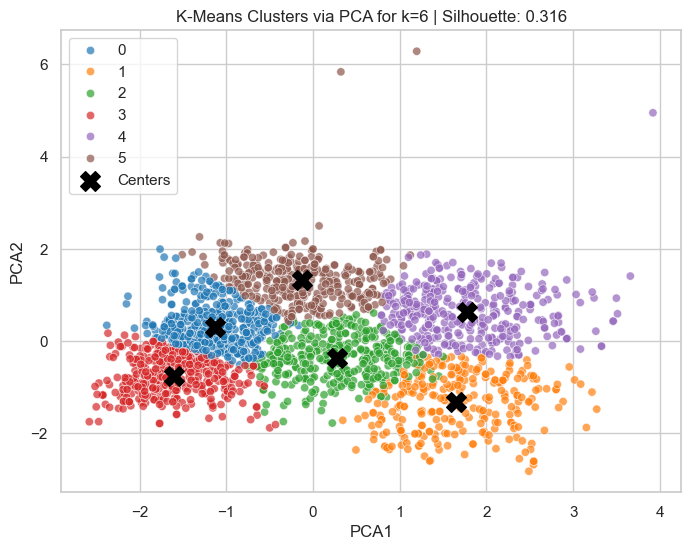

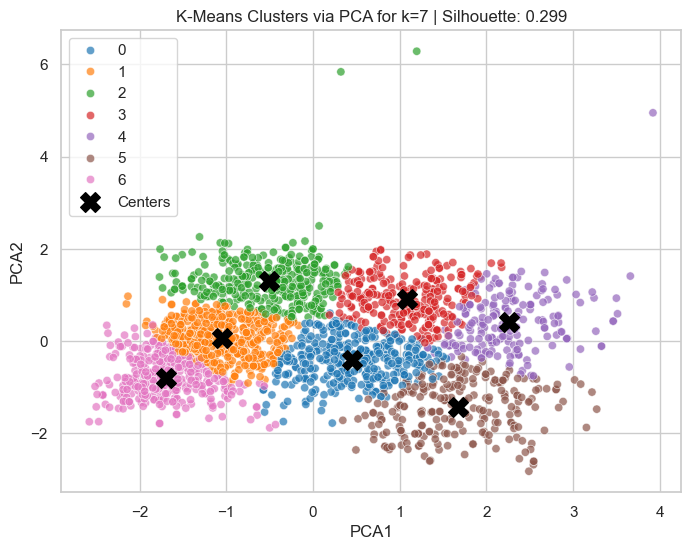

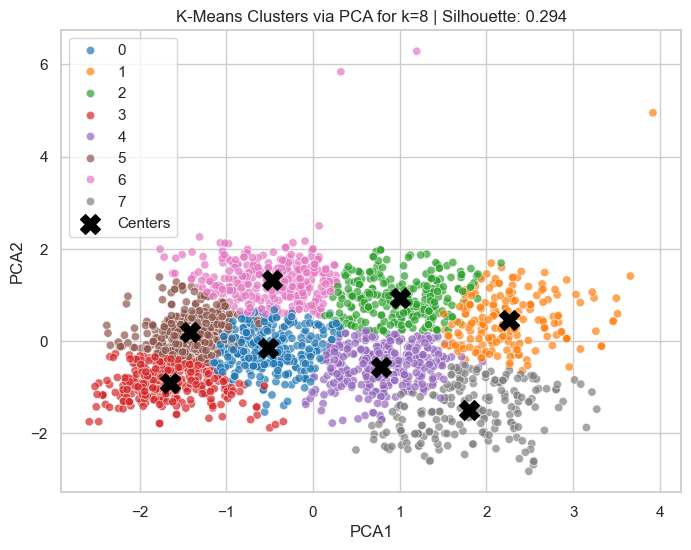

Best K for K-Means based on silhouette score: 2


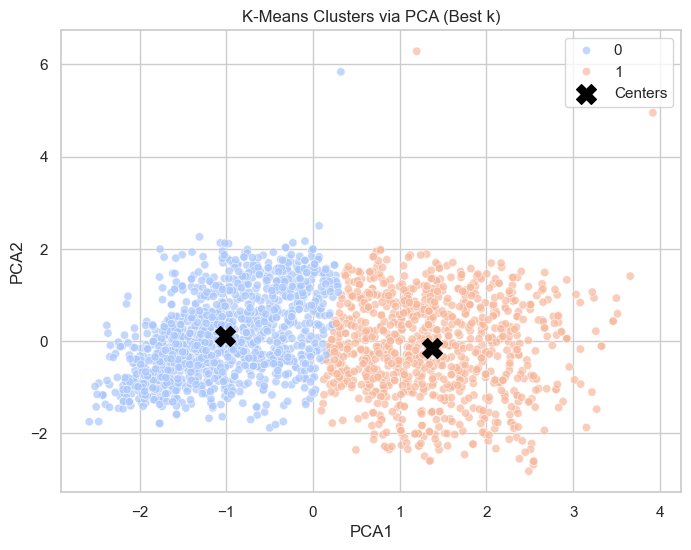

In [17]:
print("\n----- K-Means Clustering -----")
sse = []
silhouette_scores = []
k_values = range(2, 9)
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    sse.append(km.inertia_)
    labels = km.labels_
    silhouette_scores.append(silhouette_score(X, labels))
    
# Plot Elbow Curve
plt.figure(figsize=(8,4))
plt.plot(k_values, sse, marker='o')
plt.title("Elbow Curve for K-Means")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.show()

# Plot Silhouette Scores for K-Means
plt.figure(figsize=(8,4))
plt.plot(k_values, silhouette_scores, marker='s', color='red')
plt.title("Silhouette Scores for K-Means")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

# --- Additional Visualizations for K-Means with Each k Value ---
print("\n----- Additional K-Means Cluster Visualizations for each k -----")
for k in k_values:
    km_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = km_temp.fit_predict(X)
    silhouette_temp = silhouette_score(X, labels_temp)
    data['Temp_KMeans'] = labels_temp  # Temporary label column
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=data, x='PCA1', y='PCA2', hue='Temp_KMeans', palette='tab10', alpha=0.7)
    # Project cluster centers onto PCA space
    centers_temp = km_temp.cluster_centers_
    centers_pca_temp = pca.transform(centers_temp)
    plt.scatter(centers_pca_temp[:, 0], centers_pca_temp[:, 1], s=200, c='black', marker='X', label='Centers')
    plt.title(f"K-Means Clusters via PCA for k={k} | Silhouette: {silhouette_temp:.3f}")
    plt.legend()
    plt.show()

# Determine best k for K-Means
best_k = k_values[silhouette_scores.index(max(silhouette_scores))]
print(f"Best K for K-Means based on silhouette score: {best_k}")
kmeans_best = KMeans(n_clusters=best_k, random_state=42, n_init=10)
data['Cluster_KMeans'] = kmeans_best.fit_predict(X)

# Visualization for K-Means clusters (Best k) with cluster centers
plt.figure(figsize=(8,6))
sns.scatterplot(data=data, x='PCA1', y='PCA2', hue='Cluster_KMeans', palette='coolwarm', alpha=0.7)
centers = kmeans_best.cluster_centers_
centers_pca = pca.transform(centers)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], s=200, c='black', marker='X', label='Centers')
plt.title("K-Means Clusters via PCA (Best k)")
plt.legend()
plt.show()


## Agglomerative Clustering

Next, we evaluate Agglomerative Clustering over a range of k values. We also generate a dendrogram to illustrate the hierarchical structure.



----- Agglomerative Clustering -----
Agglomerative Clustering with k=2, Silhouette Score: 0.364
Agglomerative Clustering with k=3, Silhouette Score: 0.326
Agglomerative Clustering with k=4, Silhouette Score: 0.332
Agglomerative Clustering with k=5, Silhouette Score: 0.334
Agglomerative Clustering with k=6, Silhouette Score: 0.277
Agglomerative Clustering with k=7, Silhouette Score: 0.263
Agglomerative Clustering with k=8, Silhouette Score: 0.243
Best K for Agglomerative Clustering: 2


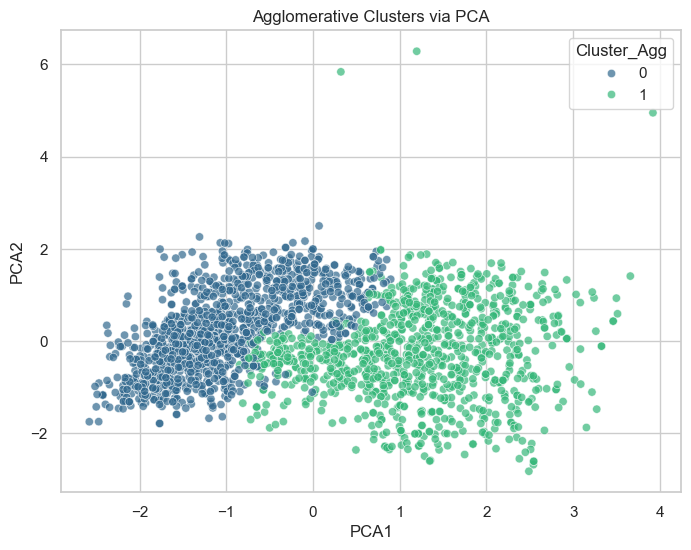

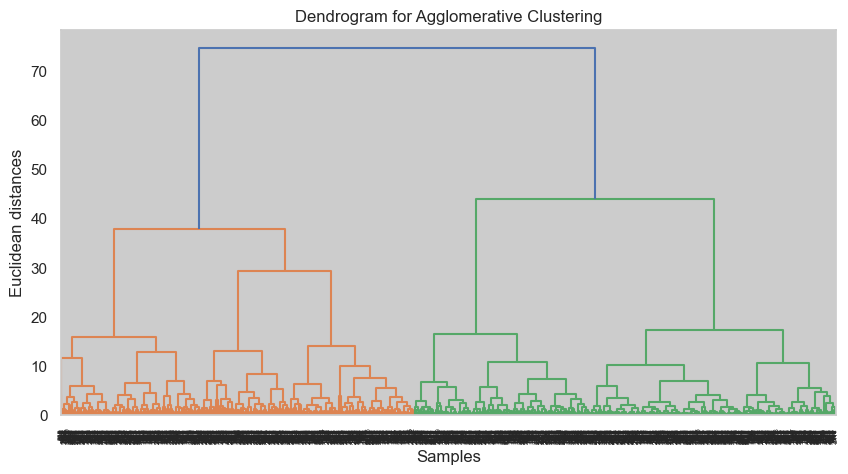

In [20]:
print("\n----- Agglomerative Clustering -----")
agglo_scores = {}
for k in k_values:
    agglo = AgglomerativeClustering(n_clusters=k)
    labels = agglo.fit_predict(X)
    score = silhouette_score(X, labels)
    agglo_scores[k] = score
    print(f"Agglomerative Clustering with k={k}, Silhouette Score: {score:.3f}")
best_k_agglo = max(agglo_scores, key=agglo_scores.get)
print(f"Best K for Agglomerative Clustering: {best_k_agglo}")
agglo_best = AgglomerativeClustering(n_clusters=best_k_agglo)
data['Cluster_Agg'] = agglo_best.fit_predict(X)

# Visualization for Agglomerative Clusters via PCA
plt.figure(figsize=(8,6))
sns.scatterplot(data=data, x='PCA1', y='PCA2', hue='Cluster_Agg', palette='viridis', alpha=0.7)
plt.title("Agglomerative Clusters via PCA")
plt.show()

# Dendrogram visualization
plt.figure(figsize=(10, 5))
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Samples')
plt.ylabel('Euclidean distances')
plt.show()


## DBSCAN Clustering

We test various epsilon values for DBSCAN and visualize the resulting clusters.



----- DBSCAN Clustering -----
DBSCAN with eps=0.5 did not yield valid clusters.
DBSCAN with eps=0.7 did not yield valid clusters.
DBSCAN with eps=0.9 did not yield valid clusters.
DBSCAN with eps=1.1 did not yield valid clusters.


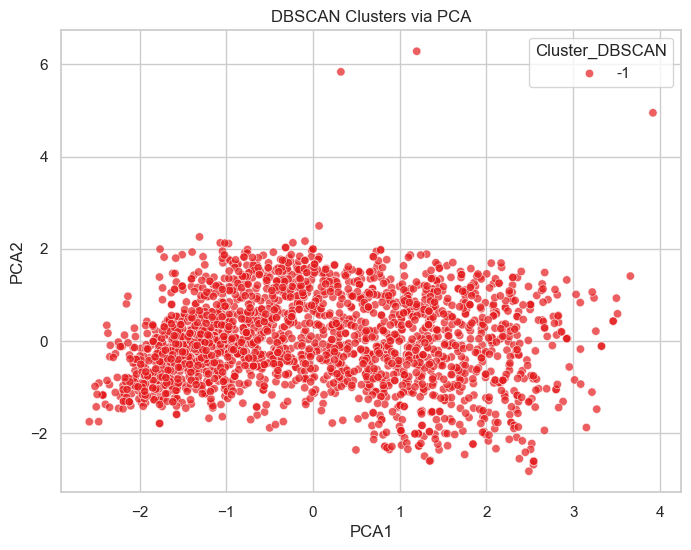

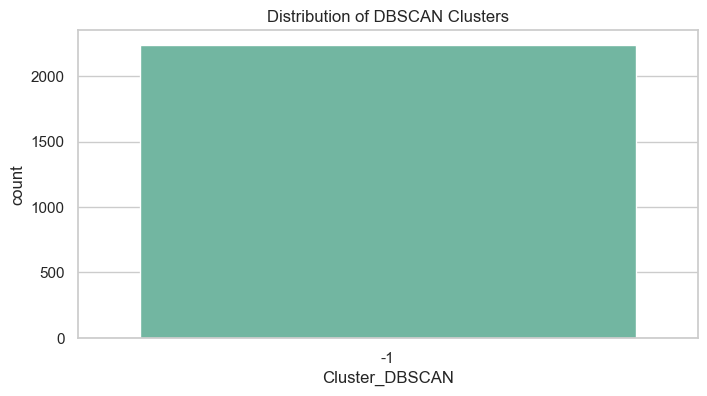

In [23]:
print("\n----- DBSCAN Clustering -----")
eps_values = [0.5, 0.7, 0.9, 1.1]
dbscan_scores = {}
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(X)
    unique_labels = set(labels)
    if len(unique_labels) > 1 and -1 not in unique_labels:
        score = silhouette_score(X, labels)
        dbscan_scores[eps] = score
        print(f"DBSCAN with eps={eps}, Silhouette Score: {score:.3f}")
    else:
        print(f"DBSCAN with eps={eps} did not yield valid clusters.")
if dbscan_scores:
    best_eps = max(dbscan_scores, key=dbscan_scores.get)
    print(f"Best eps for DBSCAN: {best_eps}")
    dbscan_best = DBSCAN(eps=best_eps, min_samples=5)
    data['Cluster_DBSCAN'] = dbscan_best.fit_predict(X)
else:
    data['Cluster_DBSCAN'] = -1

# Visualization for DBSCAN clusters via PCA
plt.figure(figsize=(8,6))
sns.scatterplot(data=data, x='PCA1', y='PCA2', hue='Cluster_DBSCAN', palette='Set1', alpha=0.7)
plt.title("DBSCAN Clusters via PCA")
plt.show()

# Bar plot showing DBSCAN cluster distribution
plt.figure(figsize=(8,4))
sns.countplot(x='Cluster_DBSCAN', data=data, palette='Set2')
plt.title("Distribution of DBSCAN Clusters")
plt.show()


## Gaussian Mixture Model (GMM) Clustering

Finally, we evaluate GMM clustering for a range of components and visualize the best model.



----- Gaussian Mixture Model (GMM) Clustering -----
GMM with 2 components, Silhouette Score: 0.296
GMM with 3 components, Silhouette Score: 0.190
GMM with 4 components, Silhouette Score: 0.192
GMM with 5 components, Silhouette Score: 0.189
GMM with 6 components, Silhouette Score: 0.139
GMM with 7 components, Silhouette Score: 0.106
GMM with 8 components, Silhouette Score: 0.073
Best number of components for GMM: 2


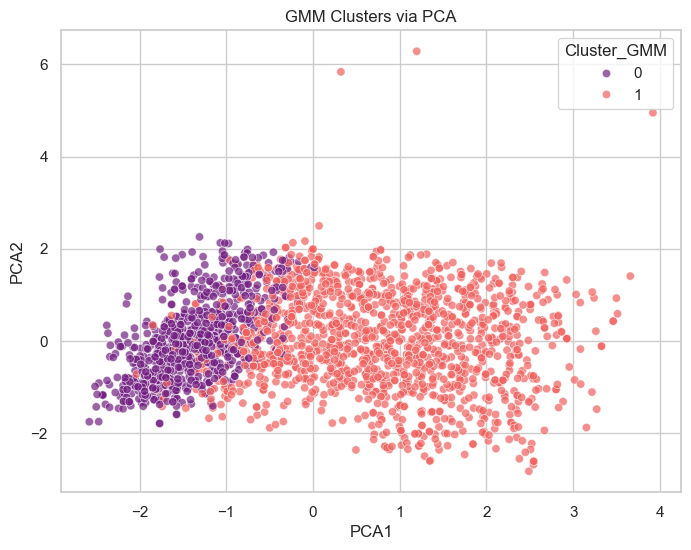

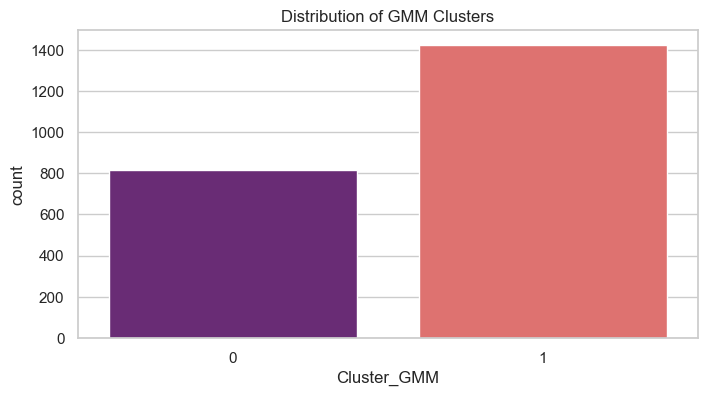

In [26]:
print("\n----- Gaussian Mixture Model (GMM) Clustering -----")
gmm_scores = {}
for n in k_values:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm_labels = gmm.fit_predict(X)
    score = silhouette_score(X, gmm_labels)
    gmm_scores[n] = score
    print(f"GMM with {n} components, Silhouette Score: {score:.3f}")
best_n_gmm = max(gmm_scores, key=gmm_scores.get)
print(f"Best number of components for GMM: {best_n_gmm}")
gmm_best = GaussianMixture(n_components=best_n_gmm, random_state=42)
data['Cluster_GMM'] = gmm_best.fit_predict(X)

# Visualization for GMM clusters via PCA
plt.figure(figsize=(8,6))
sns.scatterplot(data=data, x='PCA1', y='PCA2', hue='Cluster_GMM', palette='magma', alpha=0.7)
plt.title("GMM Clusters via PCA")
plt.show()

# Bar plot showing GMM cluster distribution
plt.figure(figsize=(8,4))
sns.countplot(x='Cluster_GMM', data=data, palette='magma')
plt.title("Distribution of GMM Clusters")
plt.show()


## Supervised Learning: Random Forest Classifier

We now predict the campaign response using the engineered features (`Income`, `Age`, `Total_Spending`) and evaluate the model.



----- Random Forest Classifier Results -----
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       572
           1       0.56      0.19      0.28       100

    accuracy                           0.86       672
   macro avg       0.72      0.58      0.60       672
weighted avg       0.83      0.86      0.83       672

Confusion Matrix:
[[557  15]
 [ 81  19]]
ROC AUC Score: 0.725


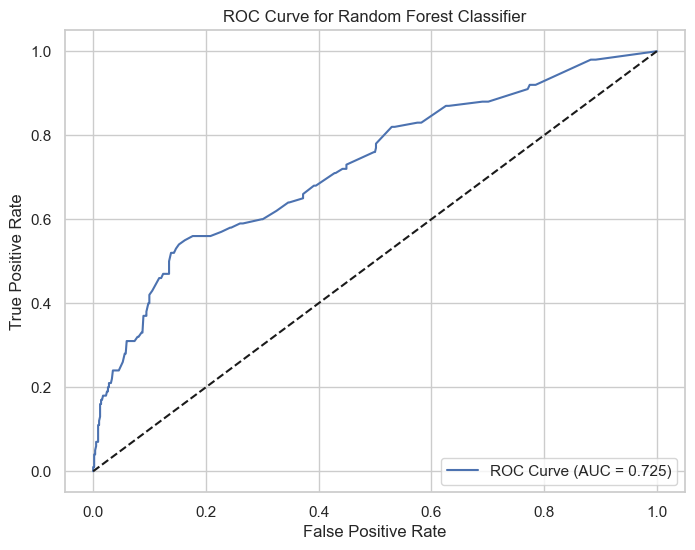

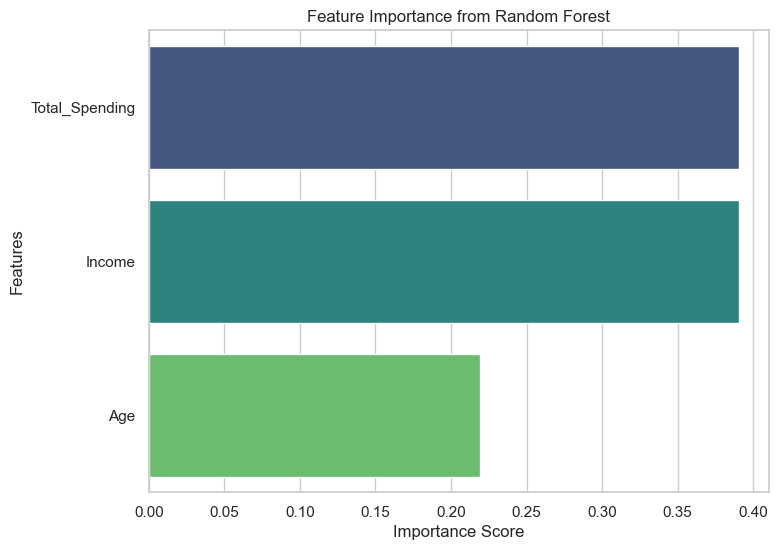

In [29]:
# Prepare data for supervised learning
X_supervised = data[clustering_features]
y_supervised = data['Response']

# Split the data (70% train, 30% test) with stratification
X_train, X_test, y_train, y_test = train_test_split(X_supervised, y_supervised,
                                                    test_size=0.3, random_state=42, stratify=y_supervised)

# Train the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions and evaluation
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]
print("\n----- Random Forest Classifier Results -----")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.3f}")

# ROC Curve Visualization
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Random Forest Classifier")
plt.legend(loc='lower right')
plt.show()

# Feature Importance Visualization
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_supervised.columns

plt.figure(figsize=(8,6))
sns.barplot(x=importances[indices], y=features[indices], palette='viridis')
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


# Conclusion

In this notebook, we:
- Cleaned and engineered features from the customer dataset.
- Explored the data through various visualizations.
- Applied multiple clustering techniques with detailed visualizations to understand the formation of clusters.
- Built and evaluated a Random Forest classifier to predict campaign response.

This structured approach provides both descriptive and predictive insights into customer segmentation. Feel free to modify parameters and visualizations as per your presentation needs!
